In [1]:
import numpy as np
from numpy.random import randn, randint
import matplotlib.pyplot as plt

from keras.datasets import mnist, fashion_mnist
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical

from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Activation

Using TensorFlow backend.


First thing we do is we define the generator part. It takes as an input the size of the input vector. We have already built generator's as this one before. 

In [ ]:
def define_generator(inp_size):
	init = RandomNormal(stddev=0.02)
 
	inp = Input(shape=(inp_size,))

	n_nodes = 7 * 7 * 256
	gen = Dense(n_nodes, kernel_initializer=init)(inp)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	gen = Reshape((7, 7, 256))(gen)

	gen = Conv2D(128, (4, 4), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)

	gen = Conv2DTranspose(64, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)

	gen = Conv2DTranspose(1, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(gen)

	out = Activation('tanh')(gen)
	model = Model(inp, out)
	return model

Next, we will define the descriminator and auxiliary models. They both take the same input but only the output is different. The best way to handle this is by creating them inside a function. We are going to define the discriminator and auxiliary function bellow. It takes two arguments as input: the number of categories and the shape of the image. The discriminator is just predicting if the input image is real or not and the auxiliary outputs one prediction for each value in the categorical variable.

In [ ]:
def define_discriminator_auxiliary(num_categories, input_shape=(28, 28, 1)):
  init = RandomNormal(stddev=0.02)
  inp = Input(shape=input_shape)

  disc = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inp)
  disc = LeakyReLU(alpha=0.1)(disc)

  disc = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(disc)
  disc = LeakyReLU(alpha=0.1)(disc)
  disc = BatchNormalization()(disc)

  disc = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(disc)
  disc = LeakyReLU(alpha=0.1)(disc)
  disc = BatchNormalization()(disc)

  disc = Flatten()(disc)
  out_disc = Dense(1, activation='sigmoid')(disc)

  disc_model = Model(inp, out_disc)
  disc_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

  q = Dense(128)(disc)
  q = BatchNormalization()(q)
  q = LeakyReLU(alpha=0.1)(q)
  out_aux = Dense(num_categories, activation='softmax')(q)

  q_model = Model(inp, out_aux)
  return disc_model, q_model

The discriminator will be trained alone, so his weights need to be frozen for the moment. We will connect the output of the generator to the input of the discriminator and also to the input of the auxiliary model. 

The generator creates an image which will be passed through the disciminator which makes a prediction if its real or not, then the image is passed through the auxiliary network which makes a prediction of the control variable.

The model has two output layers which need different loss functions. The discriminator uses binary_crossentropy and the auxiliary model takes the categorical_crossentropy.

In [ ]:
def define_gan(gen_model, disc_model, q_model):
	disc_model.trainable = False # Set discriminator weights to not trainable

	d_output = disc_model(gen_model.output) # Connect g outputs to d inputs
	q_output = q_model(gen_model.output) # Connect g outputs to q inputs

	model = Model(gen_model.input, [d_output, q_output])

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
	return model

As we mentioned earlier the input to the generator will be randomly created data, which is called "noise".
Our function "generate_latent_points" takes as an input the size of the latent space, number of categories and the number of samples that we want.

The function returns the input concatenated vectors as input for the generator model, as well as the standalone control codes. The standalone control codes will be required when updating the generator and auxiliary models via the composite GAN model, specifically for calculating the mutual information loss for the auxiliary model.

In [ ]:
def generate_latent_points(latent_dim, num_categories, n_samples):
	z_latent = randn(latent_dim * n_samples)
	z_latent = z_latent.reshape(n_samples, latent_dim)

	cat_codes = randint(0, num_categories, n_samples)
	cat_codes = to_categorical(cat_codes, num_classes=num_categories)

	z_input = np.hstack((z_latent, cat_codes))
	return [z_input, cat_codes]

Next step is to generate real and fake samples. 

We will use a function to load our dataset. Which takes as an input the name of the dataset that we want to load. 

Also we batch our data so it consists of real and fake data. We will select a batch of data from the real dataset using the function batch_samples.

One last function we need for the data is a function to generate fake samples. It will take the generator and the generator will spit out images. Reminder, generator takes the latent points as an input.

In [ ]:
def load_dataset(dataset):
	(trainX, _), (_, _) = dataset.load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')

	X = (X - 127.5) / 127.5 # Scale down to [-1, 1]
	return X
 
def batch_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]

	y = np.ones((n_samples, 1)) # Set labels to 1 for real
	return X, y
 
def generate_fake(generator, latent_dim, num_categories, n_samples):
	z, _ = generate_latent_points(latent_dim, num_categories, n_samples)

	images = generator.predict(z)
	y = np.zeros((n_samples, 1)) # Set labels to 0 for fake
	return images, y

We can keep track of the quality of the images. After a couple of epochs we will generate images and save them, as well as the model at that epoch.

In [ ]:
def summarize_performance(step, gen_model, gan_model, latent_dim, num_categories, n_samples=100):
	X, _ = generate_fake(gen_model, latent_dim, num_categories, n_samples) # Create fake images
	X = (X + 1) / 2.0 # Scale them from [-1, 1] to [0, 1]

	for i in range(10 * 10):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap=plt.cm.gray)
	
	image = f'image_{step+1}.png'
	plt.savefig(image)
	plt.close()
	
	model_name = f'model_{step+1}.h5' # Save model
	gen_model.save(model_name)
	print(f'Save -> {image} and {model_name}')

Now we can train our infoGAN. We will train it for 10 epochs with 64 samples used in a batch. The MNIST datasets consists of 64000 images, which is 64000/64 will give us 937 batches multiplied with 10 epochs is 9370 iterations. Every iteration involves updating the discriminator with half of a batch of real and half of a batch of fake samples. Next, the GAN is updated based on batch of noise and control code inputs. The loss of the discriminator on the real and fake images as well as the loss of the generator and auxiliary are shown after every iteration.

In [ ]:
def train(gen_model, disc_model, gan_model, dataset, latent_dim, num_categories, n_epochs=10, n_batch=64):
  batch_per_epoch = int(dataset.shape[0] / n_batch)

  n_steps = batch_per_epoch * n_epochs

  half_batch = int(n_batch / 2)

  for i in range(n_steps):
    X_real, y_real = batch_samples(dataset, half_batch)
    d_loss1 = disc_model.train_on_batch(X_real, y_real)

    X_fake, y_fake = generate_fake(gen_model, latent_dim, num_categories, half_batch)

    d_loss2 = disc_model.train_on_batch(X_fake, y_fake)

    z, cat_codes = generate_latent_points(latent_dim, num_categories, n_batch)

    y_gan = np.ones((n_batch, 1)) # Create labels for fake samples

    _, g, q = gan_model.train_on_batch(z, [y_gan, cat_codes])

    print(f'-> {i+1}, c1={d_loss1}, c2={d_loss2} g={g} q={q}')

    if (i+1) % (batch_per_epoch * 1) == 0:
      summarize_performance(i, gen_model, gan_model, latent_dim, num_categories)

In [ ]:
num_categories = 10

latent_dim = 62

disc_model, q_model = define_discriminator_auxiliary(num_categories)

gen_input = latent_dim + num_categories
gen_model = define_generator(gen_input)

gan_model = define_gan(gen_model, disc_model, q_model)

dataset = load_dataset(mnist)

train(gen_model, disc_model, gan_model, dataset, latent_dim, num_categories)

Let's take a look at our generated images.

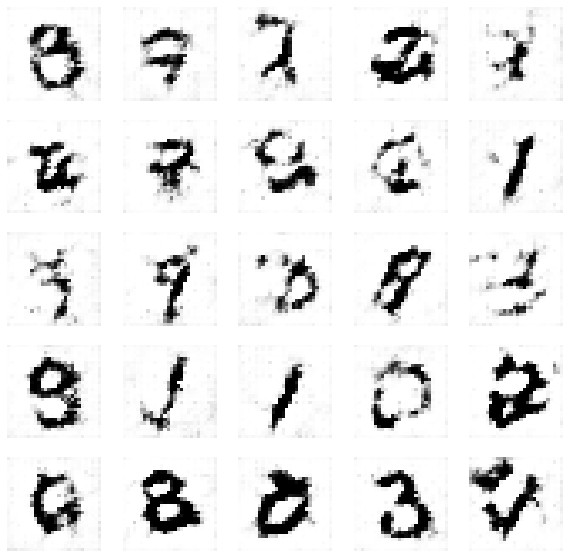

In [ ]:
X, _ = generate_fake(gen_model, latent_dim, 10, 25)
X = (X + 1) / 2.0

fig = plt.figure(figsize=(10, 10))

for i in range(5 * 5):
  ax = fig.add_subplot(5, 5, i+1)
  ax.axis('off')
  ax.imshow(X[i, :, :, 0], cmap='gray_r')